In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [2]:
class LooCVModel:
    def __init__(self, estimator):
        self.estimator = estimator
    
    def predict_from_CV(self, X, y, param_grid=None, scoring="f1", n_jobs=1):
        self.X = X
        self.y = y
        self.y_pred = []
        self.y_score = []
        self.y_true = []
        self.param_grid = param_grid
        self.scoring = scoring
        self.n_jobs = n_jobs
        self.oversampling = oversampling
        self.coef = np.zeros(X.shape)
        for i, (X_train, X_test, y_train, y_test) in enumerate(self._fold_generator()):
            if not self.param_grid:
                clf = self.estimator.fit(X_train, y_train)
            else:
                clf = GridSearchCV(self.estimator, self.param_grid, 
                                   scoring=self.scoring, cv=3, 
                                   n_jobs=self.n_jobs).fit(X_train, y_train).best_estimator_
            self.y_pred.append(clf.predict(X_test)[0])
            self.y_score.append(clf.predict_proba(X_test)[0,1])
            self.y_true.append(y_test[0])
            self.coef[i,:] = clf.feature_importances_.reshape(-1,)
        return self
              
    def _fold_generator(self):
        for train_index, test_index in LeaveOneOut().split(self.X):
            yield self.X[train_index], self.X[test_index], self.y[train_index], self.y[test_index]
    
    def feature_importance(self, names, top_features=10, direction="both", plot=None):
        f_ctr = np.median(self.coef, axis=0)
        if direction is "both":
            idx = np.argsort(np.abs(f_ctr))[:-top_features:-1]
        elif direction is "positive":
            idx = np.argsort(f_ctr)[:-top_features:-1]
        elif direction is "negative":
            idx = np.argsort(-f_ctr)[:-top_features:-1]
        fig = plt.figure(1, figsize=(8,4))
        ax = fig.add_subplot(111)
        bp = ax.boxplot(self.coef[:,idx], vert=False)
        ax.yaxis.tick_right()
        ax.set_yticklabels(np.array(names)[idx])
        for box, median in zip(bp["boxes"], bp["medians"]):
            box.set(color='#7570b3', linewidth=2)
            #box.set(facecolor="#1b9e77")
            median.set(color='#b2df8a', linewidth=2)
        if plot:
            plt.savefig("features-imp.eps")
        plt.show()

    def evaluate(self, plot=None):
        self.accuracy = accuracy_score(self.y_true, self.y_pred)
        self.precision = precision_score(self.y_true, self.y_pred)
        self.recall = recall_score(self.y_true, self.y_pred)
        self.f1 = f1_score(self.y_true, self.y_pred)
        print("Accuracy = {:.3f}".format(self.accuracy))
        print("Precision = {:.3f}".format(self.precision))
        print("Recall = {:.3f}".format(self.recall))
        print("F1 = {:.3f}\n".format(self.f1))
        
        fig, ax = plt.subplots(1,2, figsize=(8,4))
        # plot ROC curve
        clf_fpr_tpr_auc = []
        clf_fpr, clf_tpr, _ = roc_curve(self.y_true, self.y_score)
        clf_fpr_tpr_auc = (clf_fpr, clf_tpr, auc(clf_fpr, clf_tpr))
        ax[0].plot(clf_fpr_tpr_auc[0], clf_fpr_tpr_auc[1], color="#7fc97f",lw=2, label="area = {:.3f}".format(clf_fpr_tpr_auc[2]))
        ax[0].plot([0, 1], [0, 1], color="black", lw=2, linestyle="--")
        ax[0].fill_between(clf_fpr_tpr_auc[0], clf_fpr_tpr_auc[1], color="#7fc97f", alpha=0.3)
        ax[0].set_xlim([0.0, 1.0])
        ax[0].set_ylim([0.0, 1.01])
        ax[0].set_xlabel("False Positive Rate")
        ax[0].set_ylabel("True Positive Rate")
        ax[0].set_title("ROC curve")
        ax[0].legend(loc="lower right") 
        
        # plot precision-recall curve
        precisions, recalls, _ = precision_recall_curve(self.y_true, self.y_score)
        ax[1].plot(recalls, precisions, color="b", lw=2, label="area = {:.3f}".format(auc(recalls, precisions)))
        ax[1].fill_between(recalls, precisions, color="b", alpha=0.3)
        ax[1].set_xlim([0.0, 1.0])
        ax[1].set_ylim([0.0, 1.0])
        ax[1].set_xlabel("Recall")
        ax[1].set_ylabel("Precision")
        ax[1].set_title("PR curve")
        ax[1].legend(loc="lower right")
        fig.tight_layout()
        if plot:
            plt.savefig("plot-curves.eps")
        plt.show()      

In [3]:
X = np.genfromtxt("quantifier-results-CD_C-spanish-for-ML.txt", skip_header=2, usecols=range(1,93)).T
y = np.genfromtxt("spanish-C-CD-metadata.tsv", skip_header=1, usecols=[1])
feature_names = np.genfromtxt("quantifier-results-CD_C-spanish-for-ML.txt", skip_header=2, usecols=[0], dtype=str).reshape(-1,)

//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/cla

Accuracy = 0.902
Precision = 0.800
Recall = 0.762
F1 = 0.780



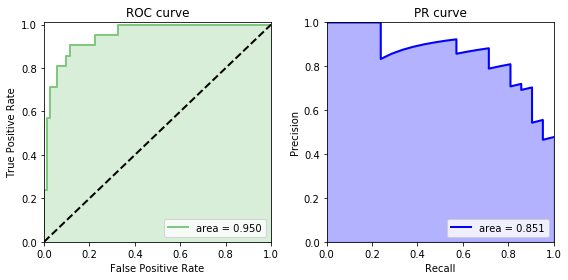

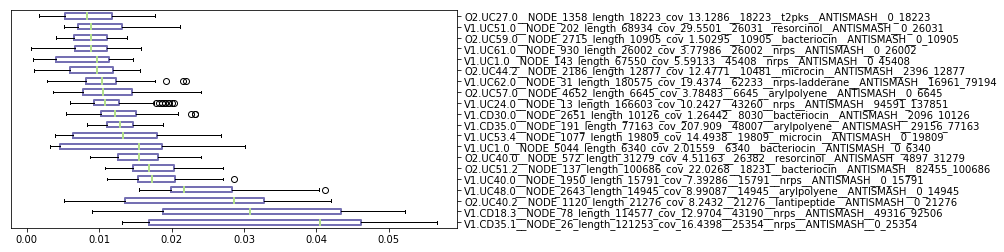

In [4]:
clf = RandomForestClassifier(n_estimators = 200, class_weight="balanced",random_state = 913)

param_grid_RF = { 
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
}

LOO_clf = LooCVModel(clf).predict_from_CV(X, y, scoring="f1", param_grid=param_grid_RF) # tune hyperparameters in param_grid, as usual
# evaluate results with many metrics and plot ROC and PR curves
LOO_clf.evaluate(plot=True)
# select top 20 features and plot feature importance in boxplot
LOO_clf.feature_importance(names=feature_names, top_features=21, plot=True) 

In [5]:
LOO_clf.estimator

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=913,
            verbose=0, warm_start=False)

In [11]:
from sklearn.externals import joblib

In [13]:
# save the model to disk
filename = 'finalized_model-RF-Metahit-C-CD.sav'
joblib.dump(LOO_clf, filename)
 
# some time later...
 
# load the model from disk
#loaded_model = joblib.load(filename)

['finalized_model-RF-Metahit-C-CD.sav']